# 2: Random Warmup

In this notebook, we explore the results generated by the `2_randomwarmup.sh` script, where we reduce the number of total episodes from 50k (see `1_bruteforce.ipynb`) to 20k and make the agents start with a random policy 10k _steps_ before their actual training starts.
This way, their can fill up their buffer(s) with random (i.e., not biased) experiences before they start learning from them.

The idea is that this should help the agents overcome the initial bias they seem to be suffering from in the first $\pm$ 20k episodes.
If we see any improvements to their rewards and/or action biases, we can infer that using a random warmup is a good idea.

The configurations that we explore are largely similar to the brute force experiments.
The only difference being that for the agents using TN, the target network update frequency is reduced from 2.5k to 1k.
This way, the target network is now updated just as many times as in the brute force experiments.

The other settings are also pretty much the same, but with these adjustments:

| parameter                     | previous value | new value
|-------------------------------|----------------|----------
| number of individual runs     | 6              | 5
| number of episodes            | 50k            | 20k
| number of random warmup steps | 0              | 10k

In addition to the above, we also explore the difference between two distinct annealing schemes for the $\varepsilon$-greedy exploration strategy.

The first one is the one we used in the brute force experiments, where the $\varepsilon$ value is exponentially annealed from 1 to 0.01 over the course of the first 80% of the total number of episodes.
The second one is a slightly less aggressive annealing scheme, where the $\varepsilon$ value is annealed linearly from 1 to 0.1 over the course of the first 50% of the total number of episodes.

| scheme | from | to   | window | kind
|--------|------|------|--------|------
| 0      | 1    | 1    | 0      | -
| 1      | 1    | 0.01 | 80%    | exponential
| 2*     | 1    | 0.01 | 80%    | linear
| 3*     | 1    | 0.1  | 50%    | exponential
| 4      | 1    | 0.1  | 50%    | linear

\* Schemes 2 and 3 are not examined in this project, but are included in the `agent.annealing` module for possible later exploration.

## Preliminaries

In [1]:
import os

from dql.utils.namespaces import P
from dql.utils.datamanager import ConcatDataManager
from dql.utils.plotter import ColorPlot, LossPlot, ComparisonPlot

import numpy as np
import matplotlib.pyplot as plt

Check if we have the data.

Should be BL, ER, TN, and TR for both annealing schemes.

In [2]:
runIDs = [f for f in os.listdir(P.data) if f.startswith('AA')]
print('\n'.join(runIDs))

AA4-TR
AA1-ER
AA4-TN
AA1-TR
AA1-TN
AA4-ER
AA4-BL
AA1-BL


Check if the parameters are correct.
We check for the run using the `TR` config, since it will contain all the hyperparameters.
For the first annealing scheme, we print the full summary.

In [3]:
ConcatDataManager('AA1-TR').printSummary()

meta:
	runID: AA1-TR
	numRepetitions: 5
	numEpisodes: 20000
	runs: 5
params:
	explorationStrategy: egreedy
	annealingScheme:
		id: 1
		startVal: 1.0
		endVal: 0.01
		window: 0.8
		kind: exponential
	experienceReplay: True
	targetNetwork: True
	replayBufferSize: 100000
	targetFrequency: 1000
	alpha: 0.0010
	gamma: 0.9990
	batchSize: 512
results:
	avgRuntime: 15:53.699 min
	avgReward: 27.0404
	avgActionBias: 0.5812
	avgLoss: 1.4840


The `AA4` run only differs in annealing scheme, so we load and print this separately.

In [4]:
for k, v in ConcatDataManager('AA4-TR').loadSummary().params.annealingScheme.items():
    print(f'{k}: {v}')

id: 4
startVal: 1.0
endVal: 0.1
window: 0.5
kind: linear


## Plotting

Define a function to easily get all figures for a given run.

In [5]:
runNames = {'BL': 'Baseline', 'ER': 'Experience Replay', 'TN': 'Target Network', 'TR': 'Target Network + Experience Replay'}

def getFigs(runID: str, exp: int) -> tuple[plt.Figure]:
    expID, epxName = ('AA1', 'Annealing Scheme 1') if exp == 1 else ('AA4', 'Annealing Scheme 4')
    
    title = f'| {runNames[runID]}\n({epxName})'
    DM = ConcatDataManager(f'{expID}-{runID}')

    R = DM.loadRewards()
    fR = ColorPlot(R, label='reward', title=title).getFig()

    A = DM.loadActions()
    AB = np.abs((A / np.sum(A, axis=2, keepdims=True))[:, :, 0] - .5) * 2
    fAB = ColorPlot(AB, label='action bias', title=title).getFig()

    L = DM.loadLosses()
    fL = LossPlot(L, title=title).getFig()
    return fR, fAB, fL

---
### Baseline

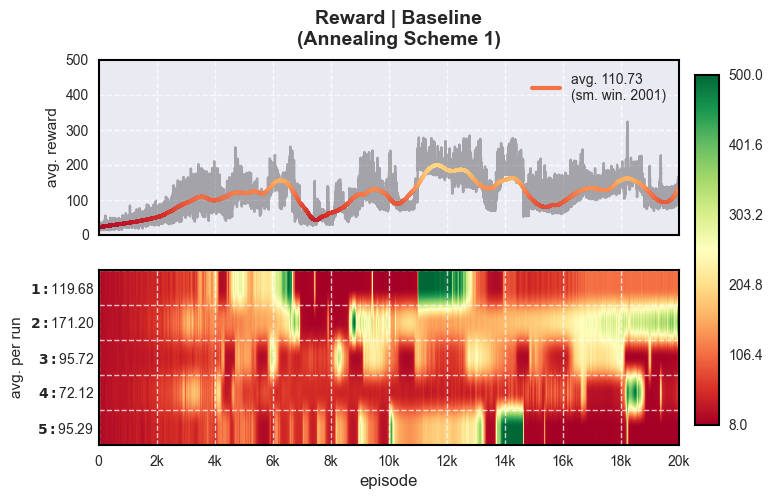

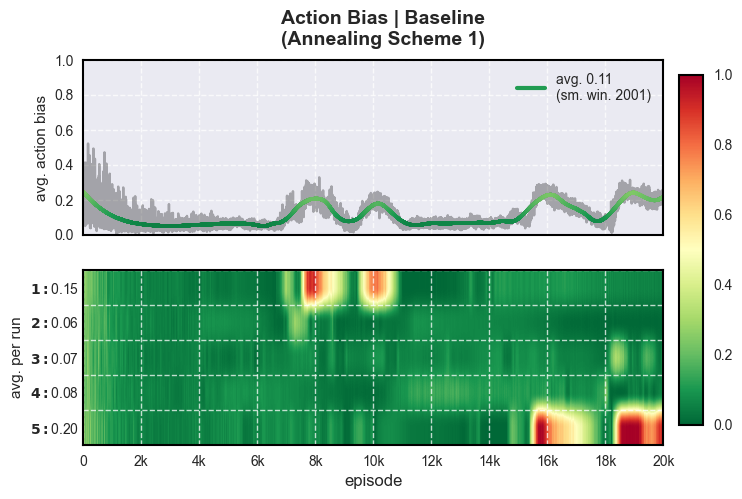

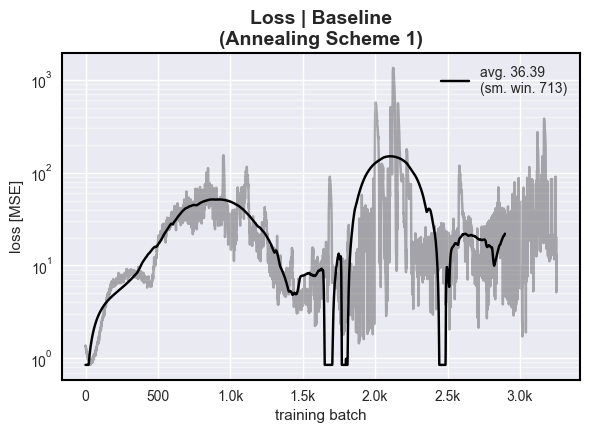

In [6]:
runID = 'BL'
rewardFig, actionBiasFig, lossFig = getFigs(runID, 1)

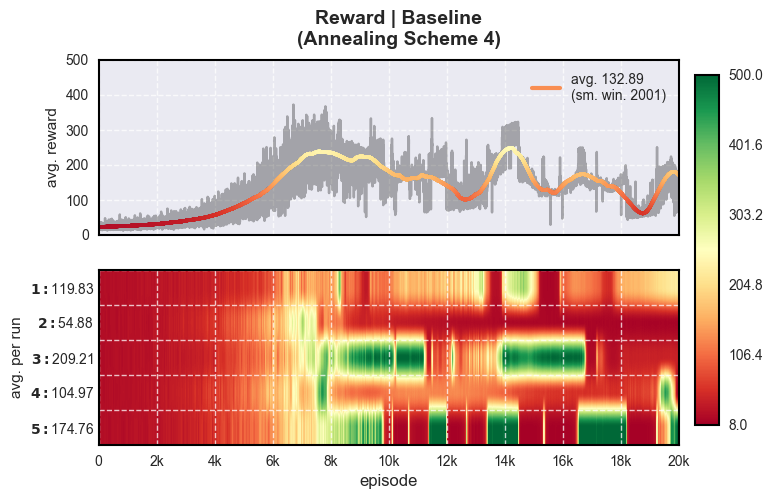

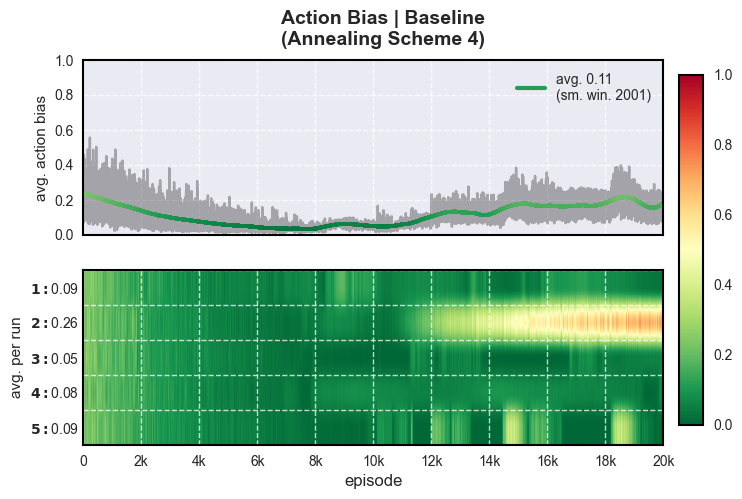

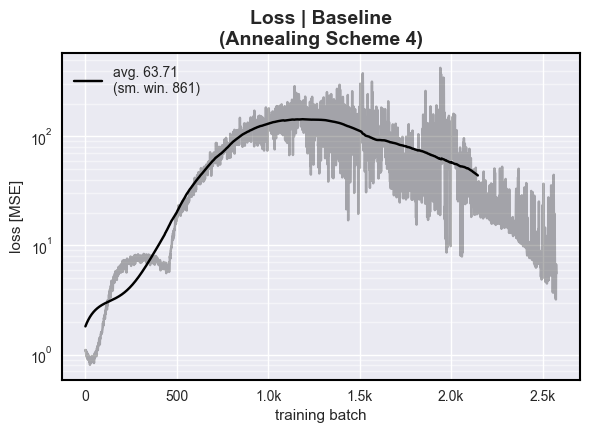

In [7]:
rewardFig, actionBiasFig, lossFig = getFigs(runID, 4)

---
### Experience Replay

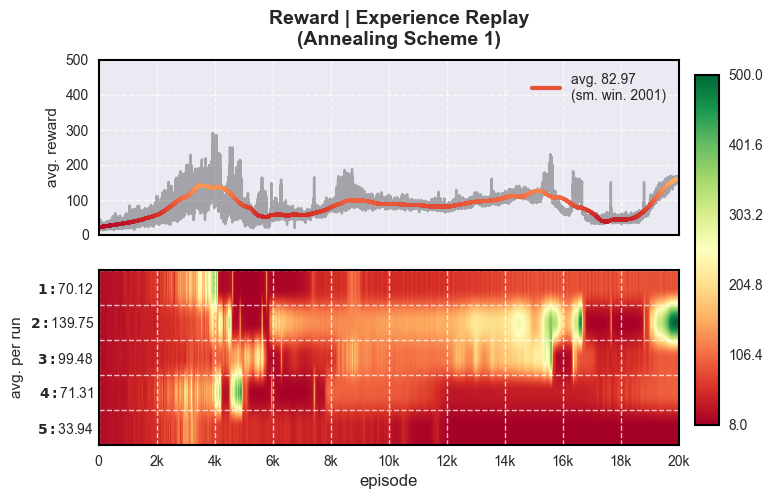

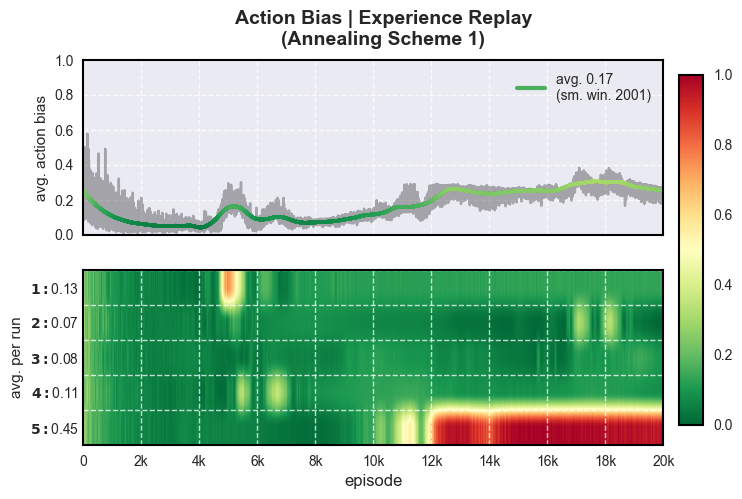

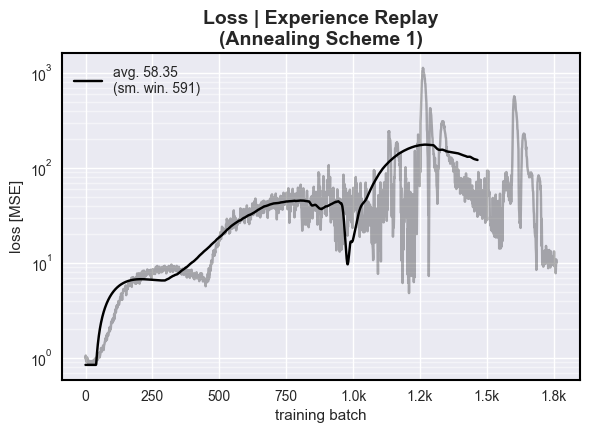

In [8]:
runID = 'ER'
rewardFig, actionBiasFig, lossFig = getFigs(runID, 1)

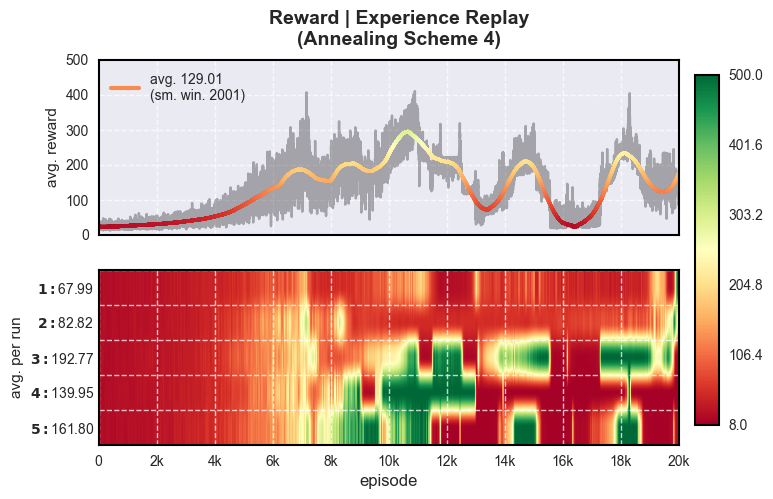

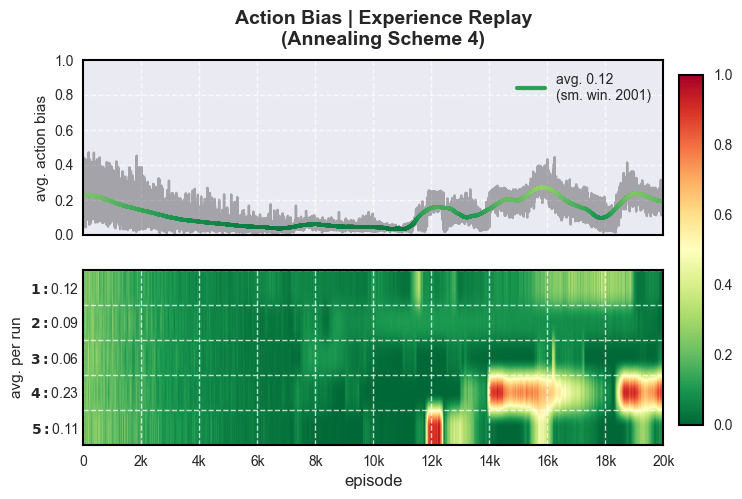

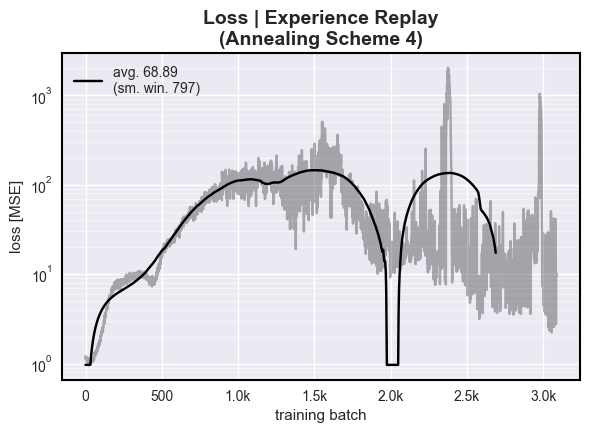

In [9]:
rewardFig, actionBiasFig, lossFig = getFigs(runID, 4)

---
### Target Network

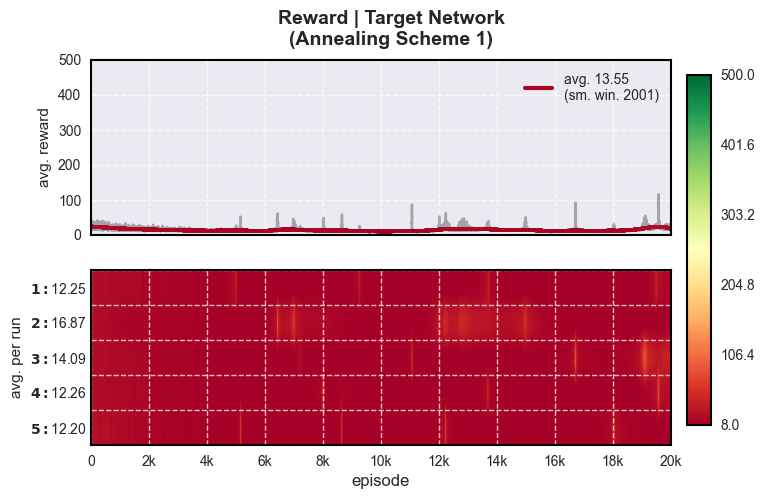

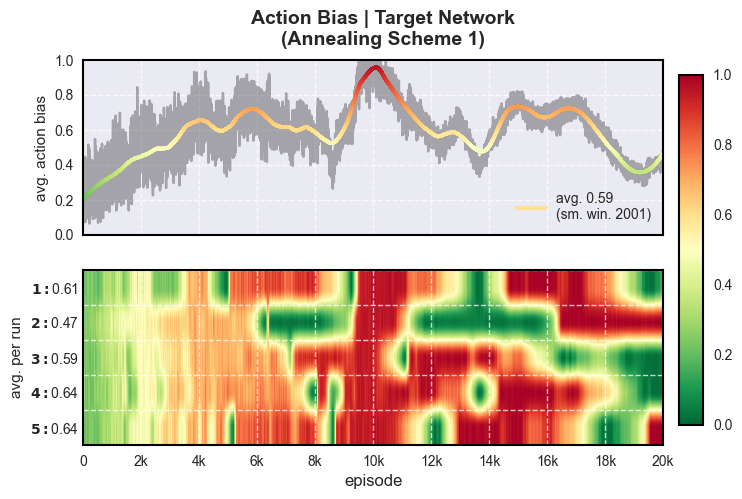

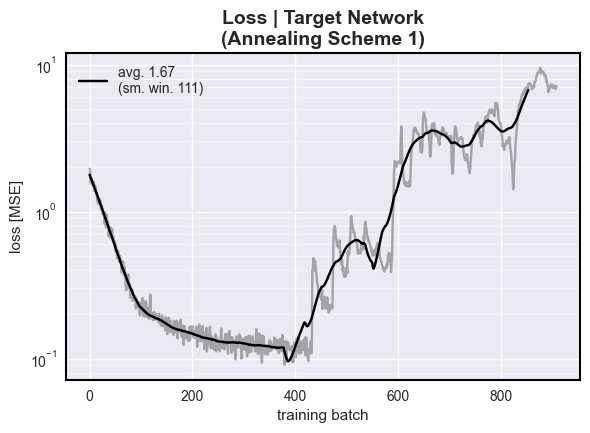

In [10]:
runID = 'TN'
rewardFig, actionBiasFig, lossFig = getFigs(runID, 1)

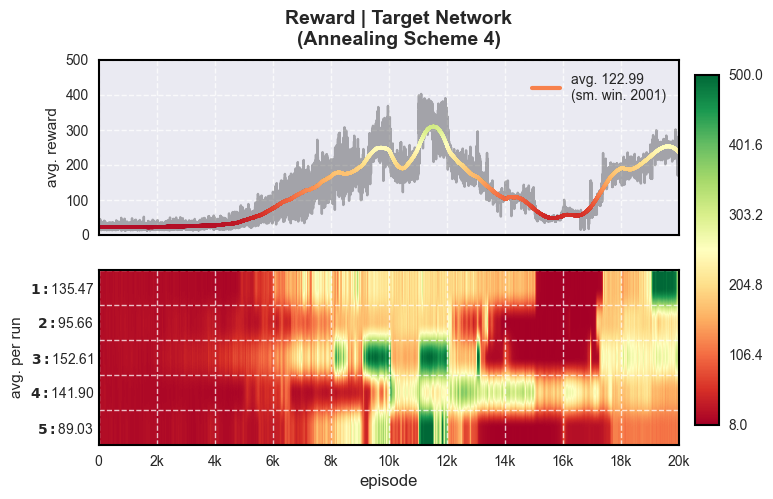

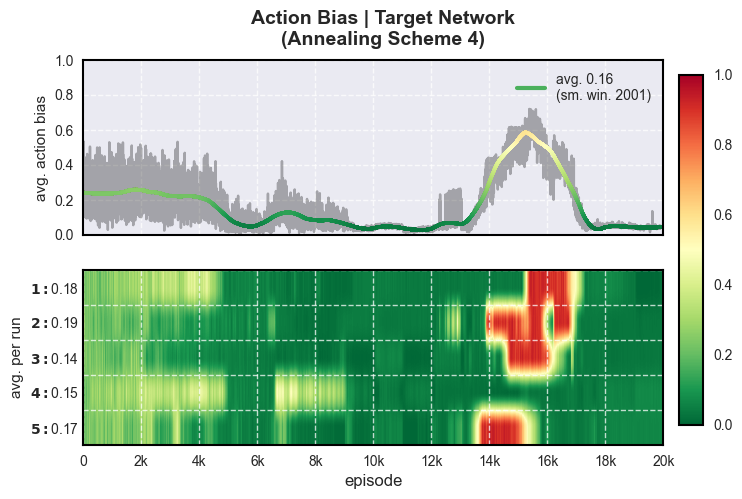

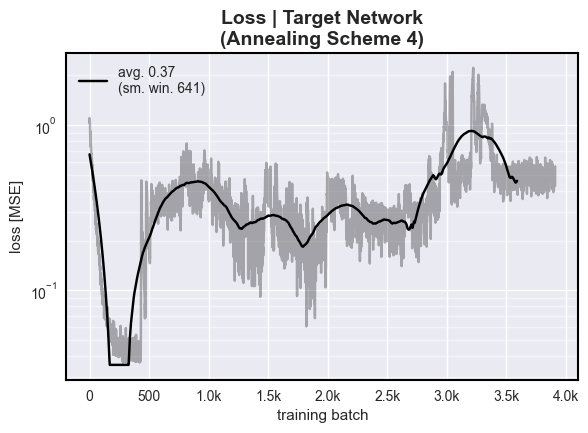

In [11]:
rewardFig, actionBiasFig, lossFig = getFigs(runID, 4)

---
### Target Network + Experience Replay

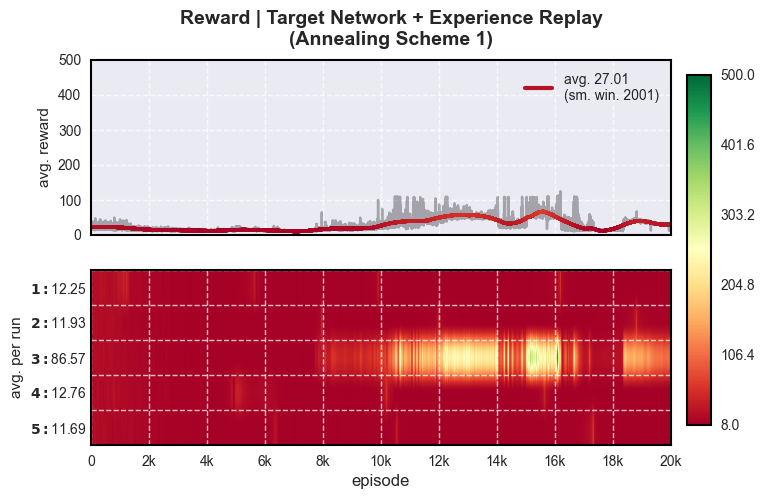

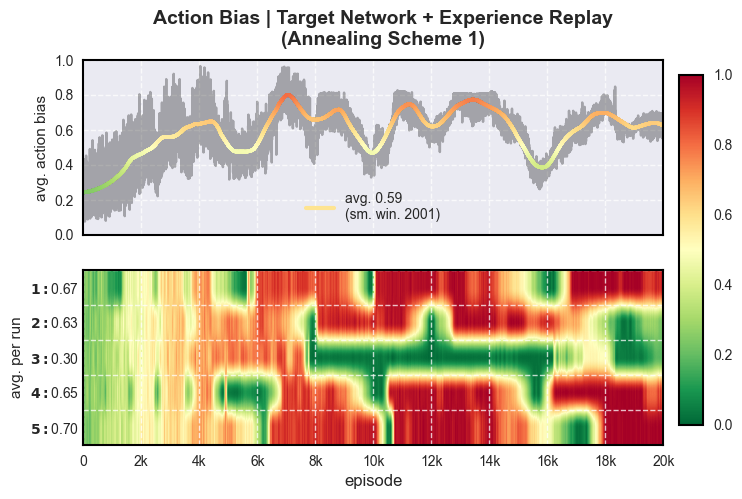

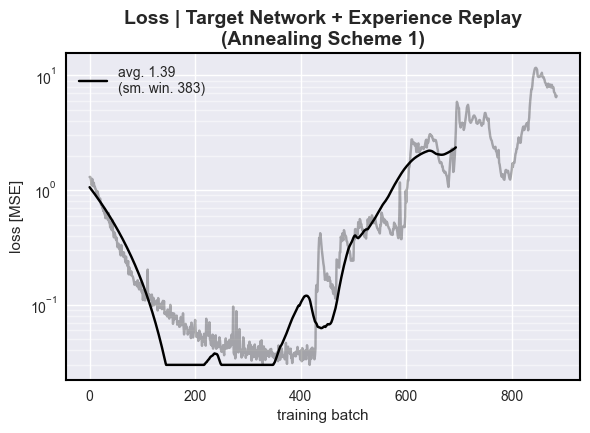

In [12]:
runID = 'TR'
rewardFig, actionBiasFig, lossFig = getFigs(runID, 1)

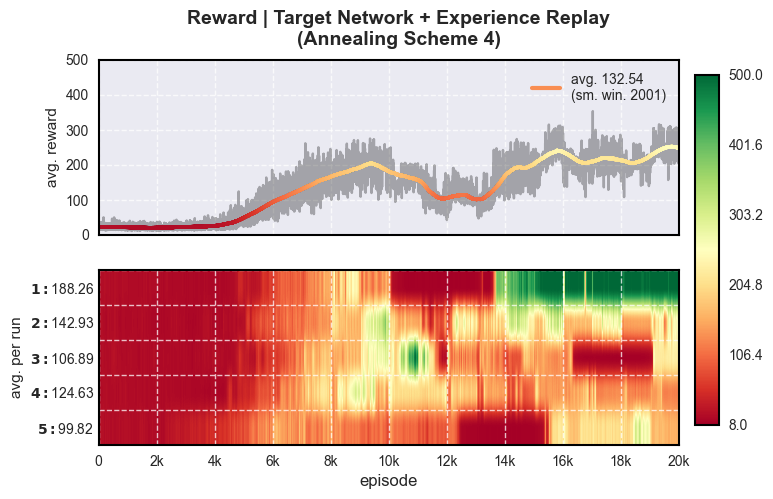

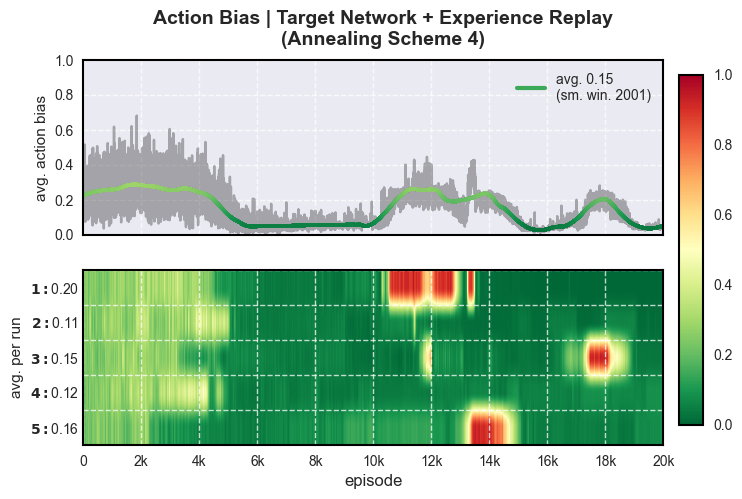

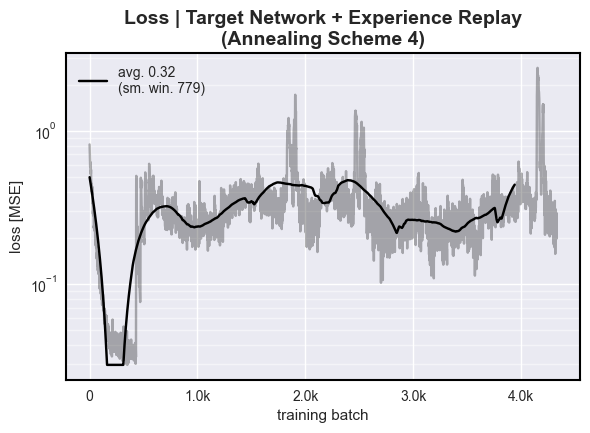

In [13]:
rewardFig, actionBiasFig, lossFig = getFigs(runID, 4)

---
### Comparison

In [14]:
data1 = []
data4 = []
# redefine runIDs to get the correct order
runIDs = ['BL', 'ER', 'TN', 'TR']
for runID in runIDs:
    DM1 = ConcatDataManager(f'AA1-{runID}')
    DM4 = ConcatDataManager(f'AA4-{runID}')
    R1, R4 = DM1.loadRewards(), DM4.loadRewards()
    A1, A4 = DM1.loadActions(), DM4.loadActions()
    AB1 = np.abs((A1 / np.sum(A1, axis=2, keepdims=True))[:, :, 0] - .5) * 2
    AB4 = np.abs((A4 / np.sum(A4, axis=2, keepdims=True))[:, :, 0] - .5) * 2
    data1.append((R1, AB1))
    data4.append((R4, AB4))

In [15]:
len(data4)

4

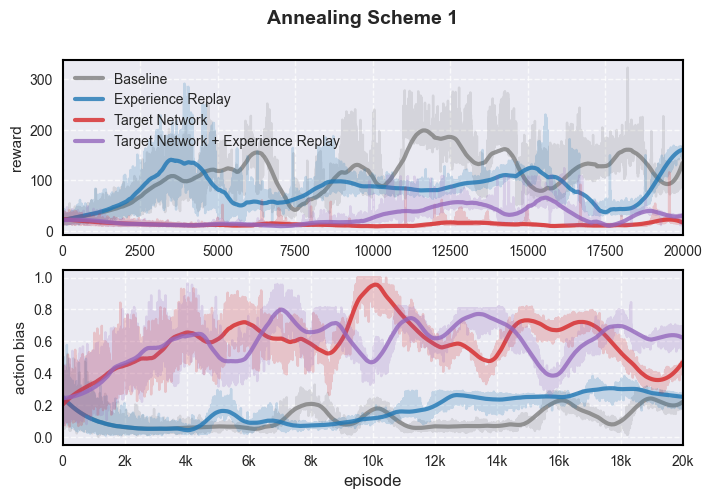

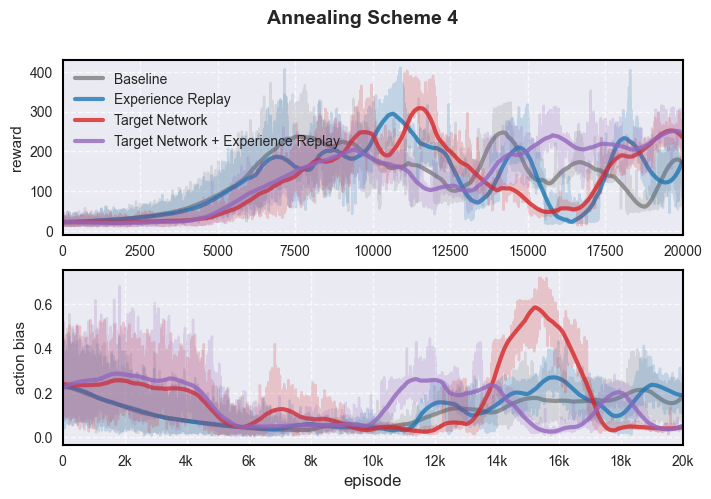

In [16]:
fig1 = ComparisonPlot(data1, runIDs, 'Annealing Scheme 1').getFig()
fig4 = ComparisonPlot(data4, runIDs, 'Annealing Scheme 4').getFig()